# Climate Indices analysis  for subseaonal forecast - Part II

Note: This verion has the XGBoost model built over for the whole year 

Model 1 - 7 day forecast (no matter when it is doing prediction/forecast i.e. 4 seasons)

Model 2 - 30 day forecast (no matter when it is doing prediction/forecast)

Evaluated the models on 3 periods -  on train, test, validation data  based on Evaluation metrics ( RMSE, MAE) - do for the 3 phases/periods separately - Freezing, melting & stable period


#### Experiment design:
1. Input variables (X):
   - Surface meterlogy, Surface water temperature, Ice cover (from previous days), climate indices- 1995 onwards
    
2. Output variables (y):
   - Ice data (1995 onwards)
    
3. Period: 
   - 1996 to 2021 (25 years). Note that 1996 includes winter of 1995/1996
   - Training(60%) - 1996 to 2010
   - Validation(20%) - 2011 to 2015
   - Test(20%) - 2016 to 2021
    
4. Predict Interval:
   - Short term foreacast: 5 days and 7 days
   - Subseasonal forecast: 5 weeks (35 days) 
    
5. Preperation of input data:
   - Surface meteorology: daily frequency data - 7 day(168 hours) history data/lag
   - Ice data: daily frequency - 7 day history/lag
   - Water Surface temperature: daily - 7 day history/lag
   - Climate indices: monthly - 3 month history/lag + daily - 7 day lag
   
            Example : If today is 1st Nov at 12 EST then inputs will be...
                  - Surface met: 25th Oct 6 EST to 1st Nov 6 EST
                  - Ice data: 25th Oct to 31st Oct
                  - Water surface temperature: 25th Oct to 31st Oct
                  - Climate indices: July,Aug,Sep
    - Note that the lag periods(7 days/3 months) can be tested in the Hyperparameter tuning phase

### 1. Preperation of Input data

In [1]:
import pandas as pd
import math
import matplotlib.pyplot as plt
%matplotlib inline   
pd.plotting.register_matplotlib_converters()           
import seaborn as sns  
import altair as alt
from vega_datasets import data
import xgboost as xgb
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [2]:
#from google.colab import drive
#drive.mount('/content/drive')

In [3]:
#meteorology = pd.read_excel("/content/drive/MyDrive/MIDAS-Code+data/Data/meteorlogy_daily.xlsx")
#surface_temp = pd.read_csv("/content/drive/MyDrive/MIDAS-Code+data/Data/Surface_Temperature_Without_Remove.csv", usecols=['Date', 'Sup.', 'Huron'], 
                           #dtype= {'Sup.':float, 'Huron':float})
#ice_data = pd.read_excel("/content/drive/MyDrive/MIDAS-Code+data/Data/ice_data_without_remove.xlsx")
#climate_ind_m = pd.read_csv("/content/drive/MyDrive/MIDAS-Code+data/Data/climate_ind_daily.csv")

In [4]:
meteorology = pd.read_excel("C:/Users/santh/MIDAS/Final_data/meteorlogy_daily.xlsx")
surface_temp = pd.read_csv("C:/Users/santh/MIDAS/Final_data/Surface_Temperature_Without_Remove.csv", usecols=['Date', 'Sup.', 'Huron'], 
                           dtype= {'Sup.':float, 'Huron':float})
ice_data = pd.read_excel("C:/Users/santh/MIDAS/Final_data/ice_data_without_remove.xlsx")
climate_ind_m = pd.read_csv("C:/Users/santh/MIDAS/Final_data/Climate_indices.csv")

In [5]:
meteorology.head()

,date,u-wind,v-wind,pressure,humidity,temperature
0,1995-01-01,2.381250,-0.628125,98903.125,30.375,270.178146
1,1995-01-02,4.033125,-1.283125,98336.875,25.500,267.714500
2,1995-01-03,5.938750,0.482500,98652.500,17.125,265.636627
3,1995-01-04,3.722500,-1.425625,99073.125,7.375,259.524513
4,1995-01-05,7.392500,2.583125,98769.375,16.625,264.535141


In [6]:
meteorology.dtypes

date           datetime64[ns]
u-wind                float64
v-wind                float64
pressure              float64
humidity              float64
temperature           float64
dtype: object

In [7]:
meteorology = meteorology.set_index('date')
meteorology.head()

,u-wind,v-wind,pressure,humidity,temperature
date,,,,,
1995-01-01,2.381250,-0.628125,98903.125,30.375,270.178146
1995-01-02,4.033125,-1.283125,98336.875,25.500,267.714500
1995-01-03,5.938750,0.482500,98652.500,17.125,265.636627
1995-01-04,3.722500,-1.425625,99073.125,7.375,259.524513
1995-01-05,7.392500,2.583125,98769.375,16.625,264.535141


In [8]:
look_back = 4 ############## This will create only 3 lags for all features since the training data contains only 5844 records.

In [9]:
lags = range(1, look_back)

meteorology = meteorology.assign(**{
    f'{col}{lag}': meteorology[col].shift(lag)
    for lag in lags
    for col in meteorology
})

meteorology.head(10)

,u-wind,v-wind,pressure,humidity,temperature,u-wind1,v-wind1,pressure1,humidity1,temperature1,u-wind2,v-wind2,pressure2,humidity2,temperature2,u-wind3,v-wind3,pressure3,humidity3,temperature3
date,,,,,,,,,,,,,,,,,,,,
1995-01-01,2.381250,-0.628125,98903.125,30.375,270.178146,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1995-01-02,4.033125,-1.283125,98336.875,25.500,267.714500,2.381250,-0.628125,98903.125,30.375,270.178146,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1995-01-03,5.938750,0.482500,98652.500,17.125,265.636627,4.033125,-1.283125,98336.875,25.500,267.714500,2.381250,-0.628125,98903.125,30.375,270.178146,NaN,NaN,NaN,NaN,NaN
1995-01-04,3.722500,-1.425625,99073.125,7.375,259.524513,5.938750,0.482500,98652.500,17.125,265.636627,4.033125,-1.283125,98336.875,25.500,267.714500,2.381250,-0.628125,98903.125,30.375,270.178146
1995-01-05,7.392500,2.583125,98769.375,16.625,264.535141,3.722500,-1.425625,99073.125,7.375,259.524513,5.938750,0.482500,98652.500,17.125,265.636627,4.033125,-1.283125,98336.875,25.500,267.714500
1995-01-06,5.763750,2.210625,97803.125,36.500,269.011017,7.392500,2.583125,98769.375,16.625,264.535141,3.722500,-1.425625,99073.125,7.375,259.524513,5.938750,0.482500,98652.500,17.125,265.636627
1995-01-07,0.098125,-3.118125,98220.000,8.000,262.210144,5.763750,2.210625,97803.125,36.500,269.011017,7.392500,2.583125,98769.375,16.625,264.535141,3.722500,-1.425625,99073.125,7.375,259.524513
1995-01-08,3.726875,2.000625,98293.750,11.625,264.712128,0.098125,-3.118125,98220.000,8.000,262.210144,5.763750,2.210625,97803.125,36.500,269.011017,7.392500,2.583125,98769.375,16.625,264.535141
1995-01-09,4.055000,-0.819375,99311.875,8.125,262.844383,3.726875,2.000625,98293.750,11.625,264.712128,0.098125,-3.118125,98220.000,8.000,262.210144,5.763750,2.210625,97803.125,36.500,269.011017


In [10]:
surface_temp.head()

,Date,Sup.,Huron
0,1995/1/1 0:00,3.29,4.50
1,1995/1/2 0:00,3.28,4.45
2,1995/1/3 0:00,3.27,4.39
3,1995/1/4 0:00,3.27,4.33
4,1995/1/5 0:00,3.22,4.18


In [11]:
surface_temp.dtypes

Date      object
Sup.     float64
Huron    float64
dtype: object

In [12]:
surface_temp['Date'] = pd.to_datetime(surface_temp['Date'], errors = 'coerce')
surface_temp.head()

,Date,Sup.,Huron
0,1995-01-01,3.29,4.50
1,1995-01-02,3.28,4.45
2,1995-01-03,3.27,4.39
3,1995-01-04,3.27,4.33
4,1995-01-05,3.22,4.18


In [13]:
surface_temp = surface_temp.set_index('Date')
surface_temp.head()

,Sup.,Huron
Date,,
1995-01-01,3.29,4.50
1995-01-02,3.28,4.45
1995-01-03,3.27,4.39
1995-01-04,3.27,4.33
1995-01-05,3.22,4.18


In [14]:
lags = range(1, look_back)

surface_temp = surface_temp.assign(**{
    f'{col}{lag}': surface_temp[col].shift(lag)
    for lag in lags
    for col in surface_temp
})

surface_temp.head(10)

,Sup.,Huron,Sup.1,Huron1,Sup.2,Huron2,Sup.3,Huron3
Date,,,,,,,,
1995-01-01,3.29,4.50,NaN,NaN,NaN,NaN,NaN,NaN
1995-01-02,3.28,4.45,3.29,4.50,NaN,NaN,NaN,NaN
1995-01-03,3.27,4.39,3.28,4.45,3.29,4.50,NaN,NaN
1995-01-04,3.27,4.33,3.27,4.39,3.28,4.45,3.29,4.50
1995-01-05,3.22,4.18,3.27,4.33,3.27,4.39,3.28,4.45
1995-01-06,3.19,4.06,3.22,4.18,3.27,4.33,3.27,4.39
1995-01-07,3.14,3.90,3.19,4.06,3.22,4.18,3.27,4.33
1995-01-08,3.10,3.75,3.14,3.90,3.19,4.06,3.22,4.18
1995-01-09,3.02,3.59,3.10,3.75,3.14,3.90,3.19,4.06


In [15]:
climate_ind_m.head()

,dateTime,NAO,PNA,EPNP,SOI
0,1995-01-01,0.93,0.66,1.03,-0.4
1,1995-02-01,1.14,0.73,0.05,-0.1
2,1995-03-01,1.25,0.33,0.61,0.8
3,1995-04-01,-0.85,0.29,1.13,-0.7
4,1995-05-01,-1.49,0.01,0.72,-0.4


In [16]:
climate_ind_m.dtypes

dateTime     object
NAO         float64
PNA         float64
EPNP        float64
SOI         float64
dtype: object

Observation - Climate indices data is of monthly frequency whereas the rest of the indices are of daily frequency. Hence, we need to convert the Climate indices data to daily frequency inorder to create the consolidated input file.

In [17]:
#Inorder to Upsample the Climate indices data, the dateTime feature has to be an index and has to be a datetime object. 
climate_ind_m['dateTime'] = pd.to_datetime(climate_ind_m['dateTime'], errors='coerce')
climate_ind_m.set_index('dateTime', inplace=True)
climate_ind_m.head()

,NAO,PNA,EPNP,SOI
dateTime,,,,
1995-01-01,0.93,0.66,1.03,-0.4
1995-02-01,1.14,0.73,0.05,-0.1
1995-03-01,1.25,0.33,0.61,0.8
1995-04-01,-0.85,0.29,1.13,-0.7
1995-05-01,-1.49,0.01,0.72,-0.4


In [18]:
#Resample at daily frequnecy, use the start value(in a month) to forward fill for the rest of the days in the month
climate_ind_d = climate_ind_m.resample('D', convention='start').ffill()
climate_ind_d.value_counts()

NAO    PNA    EPNP   SOI 
-3.18   0.76   0.23  -1.1    31
 0.61   0.69  -0.03   2.5    31
 0.19  -0.40  -0.58   0.9    31
       -0.05  -0.32   0.0    31
 0.20   0.41  -0.24   1.0    31
                             ..
 0.29  -0.12  -1.12   1.0    28
 0.45  -0.16   0.26   1.7    28
 0.70  -1.58  -0.12   2.7    28
 1.10   0.14  -0.89   1.1    28
 0.00   0.06  -1.28   1.4     1
Length: 319, dtype: int64

Observation - The climate indices been converted to daily level

In [19]:
#climate_ind_d.reset_index(inplace=True)
climate_ind_d.head()

,NAO,PNA,EPNP,SOI
dateTime,,,,
1995-01-01,0.93,0.66,1.03,-0.4
1995-01-02,0.93,0.66,1.03,-0.4
1995-01-03,0.93,0.66,1.03,-0.4
1995-01-04,0.93,0.66,1.03,-0.4
1995-01-05,0.93,0.66,1.03,-0.4


In [20]:
lags = range(1, look_back)

climate_ind_d = climate_ind_d.assign(**{
    f'{col}{lag}': climate_ind_d[col].shift(lag)
    for lag in lags
    for col in climate_ind_d
})

climate_ind_d.head(10)

,NAO,PNA,EPNP,SOI,NAO1,PNA1,EPNP1,SOI1,NAO2,PNA2,EPNP2,SOI2,NAO3,PNA3,EPNP3,SOI3
dateTime,,,,,,,,,,,,,,,,
1995-01-01,0.93,0.66,1.03,-0.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1995-01-02,0.93,0.66,1.03,-0.4,0.93,0.66,1.03,-0.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1995-01-03,0.93,0.66,1.03,-0.4,0.93,0.66,1.03,-0.4,0.93,0.66,1.03,-0.4,NaN,NaN,NaN,NaN
1995-01-04,0.93,0.66,1.03,-0.4,0.93,0.66,1.03,-0.4,0.93,0.66,1.03,-0.4,0.93,0.66,1.03,-0.4
1995-01-05,0.93,0.66,1.03,-0.4,0.93,0.66,1.03,-0.4,0.93,0.66,1.03,-0.4,0.93,0.66,1.03,-0.4
1995-01-06,0.93,0.66,1.03,-0.4,0.93,0.66,1.03,-0.4,0.93,0.66,1.03,-0.4,0.93,0.66,1.03,-0.4
1995-01-07,0.93,0.66,1.03,-0.4,0.93,0.66,1.03,-0.4,0.93,0.66,1.03,-0.4,0.93,0.66,1.03,-0.4
1995-01-08,0.93,0.66,1.03,-0.4,0.93,0.66,1.03,-0.4,0.93,0.66,1.03,-0.4,0.93,0.66,1.03,-0.4
1995-01-09,0.93,0.66,1.03,-0.4,0.93,0.66,1.03,-0.4,0.93,0.66,1.03,-0.4,0.93,0.66,1.03,-0.4


#### 1.1. Independent variables

In [21]:
meteorology = meteorology.reset_index()
meteorology = meteorology.rename(columns={'date': 'Date'})
meteorology.columns

Index(['Date', 'u-wind', 'v-wind', 'pressure', 'humidity', 'temperature',
       'u-wind1', 'v-wind1', 'pressure1', 'humidity1', 'temperature1',
       'u-wind2', 'v-wind2', 'pressure2', 'humidity2', 'temperature2',
       'u-wind3', 'v-wind3', 'pressure3', 'humidity3', 'temperature3'],
      dtype='object')

In [22]:
surface_temp = surface_temp.reset_index()
surface_temp.columns

Index(['Date', 'Sup.', 'Huron', 'Sup.1', 'Huron1', 'Sup.2', 'Huron2', 'Sup.3',
       'Huron3'],
      dtype='object')

In [23]:
climate_ind_d = climate_ind_d.reset_index()
climate_ind_d = climate_ind_d.rename(columns={'dateTime': 'Date'})
climate_ind_d.columns

Index(['Date', 'NAO', 'PNA', 'EPNP', 'SOI', 'NAO1', 'PNA1', 'EPNP1', 'SOI1',
       'NAO2', 'PNA2', 'EPNP2', 'SOI2', 'NAO3', 'PNA3', 'EPNP3', 'SOI3'],
      dtype='object')

In [24]:
df_merge_inter = meteorology.merge(surface_temp, how = 'inner', on = 'Date')
df_merge = df_merge_inter.merge(climate_ind_d, how = 'inner', on = 'Date')
df_merge.shape

(9678, 45)

In [25]:
df_merge.head(10)

,Date,u-wind,v-wind,pressure,humidity,temperature,u-wind1,v-wind1,pressure1,humidity1,...,EPNP1,SOI1,NAO2,PNA2,EPNP2,SOI2,NAO3,PNA3,EPNP3,SOI3
0,1995-01-01,2.381250,-0.628125,98903.125,30.375,270.178146,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1995-01-02,4.033125,-1.283125,98336.875,25.500,267.714500,2.381250,-0.628125,98903.125,30.375,...,1.03,-0.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1995-01-03,5.938750,0.482500,98652.500,17.125,265.636627,4.033125,-1.283125,98336.875,25.500,...,1.03,-0.4,0.93,0.66,1.03,-0.4,NaN,NaN,NaN,NaN
3,1995-01-04,3.722500,-1.425625,99073.125,7.375,259.524513,5.938750,0.482500,98652.500,17.125,...,1.03,-0.4,0.93,0.66,1.03,-0.4,0.93,0.66,1.03,-0.4
4,1995-01-05,7.392500,2.583125,98769.375,16.625,264.535141,3.722500,-1.425625,99073.125,7.375,...,1.03,-0.4,0.93,0.66,1.03,-0.4,0.93,0.66,1.03,-0.4
5,1995-01-06,5.763750,2.210625,97803.125,36.500,269.011017,7.392500,2.583125,98769.375,16.625,...,1.03,-0.4,0.93,0.66,1.03,-0.4,0.93,0.66,1.03,-0.4
6,1995-01-07,0.098125,-3.118125,98220.000,8.000,262.210144,5.763750,2.210625,97803.125,36.500,...,1.03,-0.4,0.93,0.66,1.03,-0.4,0.93,0.66,1.03,-0.4
7,1995-01-08,3.726875,2.000625,98293.750,11.625,264.712128,0.098125,-3.118125,98220.000,8.000,...,1.03,-0.4,0.93,0.66,1.03,-0.4,0.93,0.66,1.03,-0.4
8,1995-01-09,4.055000,-0.819375,99311.875,8.125,262.844383,3.726875,2.000625,98293.750,11.625,...,1.03,-0.4,0.93,0.66,1.03,-0.4,0.93,0.66,1.03,-0.4
9,1995-01-10,-2.220625,-1.595000,100214.375,14.500,258.141140,4.055000,-0.819375,99311.875,8.125,...,1.03,-0.4,0.93,0.66,1.03,-0.4,0.93,0.66,1.03,-0.4


#### 1.2. Target variable

In [26]:
#ice_data = ice_data.drop(list(range(0,look_back + predict_interval - 2)))
ice_data = ice_data.rename(columns={'date': 'Date'})
ice_data.head()

,Date,Ice
0,1995-01-01,0.0
1,1995-01-02,0.0
2,1995-01-03,0.0
3,1995-01-04,0.0
4,1995-01-05,0.0


In [27]:
ice_data.tail()

,Date,Ice
9673,2021-06-26,0.0
9674,2021-06-27,0.0
9675,2021-06-28,0.0
9676,2021-06-29,0.0
9677,2021-06-30,0.0


In [28]:
ice_data = ice_data.set_index('Date')
lags = range(1, look_back)

ice_data = ice_data.assign(**{
    f'{col}{lag}': ice_data[col].shift(lag)
    for lag in lags
    for col in ice_data
})

ice_data = ice_data.reset_index()
ice_data.head(10)

,Date,Ice,Ice1,Ice2,Ice3
0,1995-01-01,0.000000,NaN,NaN,NaN
1,1995-01-02,0.000000,0.000000,NaN,NaN
2,1995-01-03,0.000000,0.000000,0.0,NaN
3,1995-01-04,0.000000,0.000000,0.0,0.0
4,1995-01-05,0.000000,0.000000,0.0,0.0
5,1995-01-06,0.000000,0.000000,0.0,0.0
6,1995-01-07,0.000000,0.000000,0.0,0.0
7,1995-01-08,0.000000,0.000000,0.0,0.0
8,1995-01-09,62.446242,0.000000,0.0,0.0
9,1995-01-10,77.650264,62.446242,0.0,0.0


#### 1.3. Normalization

In [29]:
# normalize the input data

scaler_train = MinMaxScaler(feature_range=(0,1))
input_columns = df_merge.iloc[:,1:].columns
standard_array = scaler_train.fit_transform(df_merge.iloc[:,1:].values) 
df_norm = pd.DataFrame(standard_array)
df_norm.columns = input_columns

# reset the index for the date dataframe
df_norm = pd.concat([df_merge.iloc[:,0].to_frame().reset_index(drop=True), df_norm], axis = 1)
df_norm.head()

,Date,u-wind,v-wind,pressure,humidity,temperature,u-wind1,v-wind1,pressure1,humidity1,...,EPNP1,SOI1,NAO2,PNA2,EPNP2,SOI2,NAO3,PNA3,EPNP3,SOI3
0,1995-01-01,0.615115,0.473178,0.516700,0.384348,0.417669,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1995-01-02,0.711702,0.427545,0.410524,0.316522,0.372446,0.615115,0.473178,0.516700,0.384348,...,0.608403,0.45,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1995-01-03,0.823125,0.550553,0.469706,0.200000,0.334305,0.711702,0.427545,0.410524,0.316522,...,0.608403,0.45,0.718531,0.650442,0.608403,0.45,NaN,NaN,NaN,NaN
3,1995-01-04,0.693539,0.417617,0.548576,0.064348,0.222110,0.823125,0.550553,0.469706,0.200000,...,0.608403,0.45,0.718531,0.650442,0.608403,0.45,0.718531,0.650442,0.608403,0.45
4,1995-01-05,0.908127,0.696900,0.491621,0.193043,0.314086,0.693539,0.417617,0.548576,0.064348,...,0.608403,0.45,0.718531,0.650442,0.608403,0.45,0.718531,0.650442,0.608403,0.45


In [30]:
df_data = ice_data.merge(df_norm, on = 'Date', how = 'inner')
df_data = df_data.set_index('Date')
df_data.head(10)

,Ice,Ice1,Ice2,Ice3,u-wind,v-wind,pressure,humidity,temperature,u-wind1,...,EPNP1,SOI1,NAO2,PNA2,EPNP2,SOI2,NAO3,PNA3,EPNP3,SOI3
Date,,,,,,,,,,,,,,,,,,,,,
1995-01-01,0.000000,NaN,NaN,NaN,0.615115,0.473178,0.516700,0.384348,0.417669,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1995-01-02,0.000000,0.000000,NaN,NaN,0.711702,0.427545,0.410524,0.316522,0.372446,0.615115,...,0.608403,0.45,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1995-01-03,0.000000,0.000000,0.0,NaN,0.823125,0.550553,0.469706,0.200000,0.334305,0.711702,...,0.608403,0.45,0.718531,0.650442,0.608403,0.45,NaN,NaN,NaN,NaN
1995-01-04,0.000000,0.000000,0.0,0.0,0.693539,0.417617,0.548576,0.064348,0.222110,0.823125,...,0.608403,0.45,0.718531,0.650442,0.608403,0.45,0.718531,0.650442,0.608403,0.45
1995-01-05,0.000000,0.000000,0.0,0.0,0.908127,0.696900,0.491621,0.193043,0.314086,0.693539,...,0.608403,0.45,0.718531,0.650442,0.608403,0.45,0.718531,0.650442,0.608403,0.45
1995-01-06,0.000000,0.000000,0.0,0.0,0.812893,0.670948,0.310442,0.469565,0.396245,0.908127,...,0.608403,0.45,0.718531,0.650442,0.608403,0.45,0.718531,0.650442,0.608403,0.45
1995-01-07,0.000000,0.000000,0.0,0.0,0.481618,0.299704,0.388609,0.073043,0.271408,0.812893,...,0.608403,0.45,0.718531,0.650442,0.608403,0.45,0.718531,0.650442,0.608403,0.45
1995-01-08,0.000000,0.000000,0.0,0.0,0.693795,0.656318,0.402438,0.123478,0.317334,0.481618,...,0.608403,0.45,0.718531,0.650442,0.608403,0.45,0.718531,0.650442,0.608403,0.45
1995-01-09,62.446242,0.000000,0.0,0.0,0.712981,0.459854,0.593343,0.074783,0.283050,0.693795,...,0.608403,0.45,0.718531,0.650442,0.608403,0.45,0.718531,0.650442,0.608403,0.45


In [31]:
df_data.tail(10)

,Ice,Ice1,Ice2,Ice3,u-wind,v-wind,pressure,humidity,temperature,u-wind1,...,EPNP1,SOI1,NAO2,PNA2,EPNP2,SOI2,NAO3,PNA3,EPNP3,SOI3
Date,,,,,,,,,,,,,,,,,,,,,
2021-06-21,0.0,0.0,0.0,0.0,0.536508,0.449694,0.222665,0.520000,0.708856,0.565975,...,0.391597,0.583333,0.690559,0.652655,0.391597,0.583333,0.690559,0.652655,0.391597,0.583333
2021-06-22,0.0,0.0,0.0,0.0,0.591544,0.423147,0.441502,0.274783,0.653810,0.536508,...,0.391597,0.583333,0.690559,0.652655,0.391597,0.583333,0.690559,0.652655,0.391597,0.583333
2021-06-23,0.0,0.0,0.0,0.0,0.539980,0.649380,0.512442,0.330435,0.716457,0.591544,...,0.391597,0.583333,0.690559,0.652655,0.391597,0.583333,0.690559,0.652655,0.391597,0.583333
2021-06-24,0.0,0.0,0.0,0.0,0.611472,0.784246,0.472128,0.518261,0.798457,0.539980,...,0.391597,0.583333,0.690559,0.652655,0.391597,0.583333,0.690559,0.652655,0.391597,0.583333
2021-06-25,0.0,0.0,0.0,0.0,0.462518,0.629235,0.481151,0.605217,0.767096,0.611472,...,0.391597,0.583333,0.690559,0.652655,0.391597,0.583333,0.690559,0.652655,0.391597,0.583333
2021-06-26,0.0,0.0,0.0,0.0,0.427313,0.540233,0.454510,0.457391,0.777870,0.462518,...,0.391597,0.583333,0.690559,0.652655,0.391597,0.583333,0.690559,0.652655,0.391597,0.583333
2021-06-27,0.0,0.0,0.0,0.0,0.453114,0.452684,0.406305,0.697391,0.793817,0.427313,...,0.391597,0.583333,0.690559,0.652655,0.391597,0.583333,0.690559,0.652655,0.391597,0.583333
2021-06-28,0.0,0.0,0.0,0.0,0.546229,0.513905,0.564749,0.551304,0.839706,0.453114,...,0.391597,0.583333,0.690559,0.652655,0.391597,0.583333,0.690559,0.652655,0.391597,0.583333
2021-06-29,0.0,0.0,0.0,0.0,0.473042,0.607013,0.604711,0.615652,0.830244,0.546229,...,0.391597,0.583333,0.690559,0.652655,0.391597,0.583333,0.690559,0.652655,0.391597,0.583333


In [32]:
# Importing packages for XGBoost and K-fold Gridsearch
# In Anacomnda command propmpt execute the command conda install -c anaconda py-xgboost
from xgboost import XGBRegressor
import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [33]:
df_data['Ice'] = df_data['Ice'].shift(-7)
df_data = df_data.dropna()

In [34]:
X = df_data.drop(['Ice'], axis = 1) ####### This is to include ice lags
###### X = df_data.drop(['Ice', 'Ice1', 'Ice2', 'Ice3'], axis = 1) ########## This is to exclude ice lags
y = df_data['Ice']

In [35]:
X_train = X['1995-01-01':'2010-12-31']
X_valid = X['2011-01-01':'2015-12-31']
y_train = y['1995-01-01':'2010-12-31']
y_valid = y['2011-01-01':'2015-12-31']

print(X_train.shape, y_train.shape)
print(X_valid.shape, y_valid.shape)

(5841, 47) (5841,)
(1826, 47) (1826,)


In [36]:
X_test = X['2016-01-01':'2021-06-30']
y_test = y['2016-01-01':'2021-06-30']
print(X_test.shape, y_test.shape)

(2001, 47) (2001,)


In [37]:
# Running the XGBoost regressor with a wide range of hyper parameters and timeseries split
import time
t0 = time.time()

xgb1 = xgb.XGBRegressor()
parameters = {'objective' : ['reg:squarederror'],
              #'objective':['reg:tweedie'],
              'booster': ['gbtree', 'gblinear'],
              'early_stopping_rounds' : [20],
              'learning_rate': [0.005],
              'max_depth': [3],
              'subsample': [0.5, 0.6, 0.7],
              'colsample_bytree': [0.5, 0.6],
              'n_estimators': [1500],
              'eval_metric' : ['rmse'],
              'eval_set' : [[X_valid, y_valid]]}

tscv = TimeSeriesSplit(n_splits=10)

xgb_grid = GridSearchCV(xgb1,
                        parameters,
                        n_jobs = -1,
                        cv = tscv,
                        verbose=True)

xgb_grid.fit(X_train, y_train)

tF = time.time()

print(xgb_grid.best_score_)
print(xgb_grid.best_params_)

print('Time to train = %.2f seconds' % (tF - t0))

Fitting 10 folds for each of 12 candidates, totalling 120 fits
[04:37:16] WARNING: ..\src\learner.cc:541: 
Parameters: { early_stopping_rounds, eval_set } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


0.95281167387555
{'booster': 'gbtree', 'colsample_bytree': 0.6, 'early_stopping_rounds': 20, 'eval_metric': 'rmse', 'eval_set': [                 Ice1       Ice2       Ice3    u-wind    v-wind  pressure  \
Date                                                                        
2011-01-01  90.160346  89.930617  93.241438  0.494847  0.702764  0.300207   
2011-01-02  90.160346  90.160346  89.930617  0.761438  0.670542  0.419040   
2011-01-03  85.904482  90.160346  90.160346  0.656702  0.591091  0.508692   
2011-01-04  79.836571  85.904482  90.160346  0.519295  0.520480  0.42138

In [38]:
# Predicting on the Training data and calculating the mean absolute error

y_train_pred = xgb_grid.predict(X_train)

print(mean_absolute_error(y_train, y_train_pred))
print(math.sqrt(mean_squared_error(y_train, y_train_pred)))

2.6313749266093396
5.7658641012255165


In [39]:
# Predicting on the Validation data and calculating the mean absolute error

y_valid_pred = xgb_grid.predict(X_valid)

print(mean_absolute_error(y_valid, y_valid_pred))
print(math.sqrt(mean_squared_error(y_valid, y_valid_pred)))

3.8571817998612064
8.525175592696824


In [40]:
# Predicting on the test data and calculating the mean absolute error

X_test = X_test.dropna()
y_test = y_test.dropna()

y_test_pred = xgb_grid.predict(X_test)

print(mean_absolute_error(y_test, y_test_pred))
print(math.sqrt(mean_squared_error(y_test, y_test_pred)))

4.73768628286547
9.682151696936435


<AxesSubplot:ylabel='feature'>

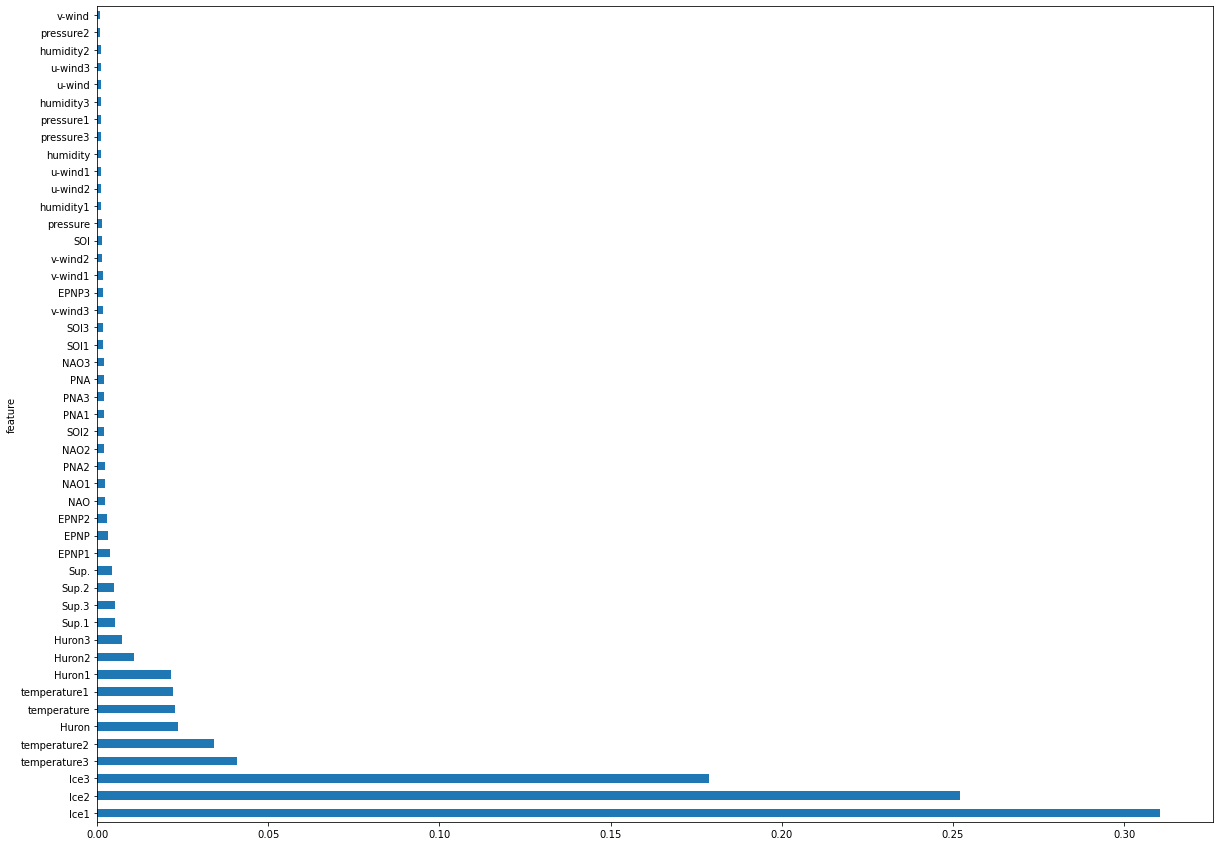

In [41]:
# Calculating variable importance as per the XGBoost model.

var_importance = pd.DataFrame(xgb_grid.best_estimator_.feature_importances_)
features = pd.DataFrame(X_test.columns)
df_var_imp = pd.concat([features, var_importance], axis = 1)
df_var_imp.columns = ['feature', 'importance']
df_var_imp = df_var_imp.sort_values(by = ['importance'], ascending = False)
df_var_imp = df_var_imp.set_index(['feature'])

# Displaying the variable importance

%matplotlib inline
fig, ax = plt.subplots(figsize=(20, 15))
#plt.figure(figsize=(10,10))
df_var_imp['importance'].plot(kind = 'barh')

<ipython-input-42-785c215a319c>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['Ice'] = y_train
<ipython-input-42-785c215a319c>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['Ice_pred'] = y_train_pred


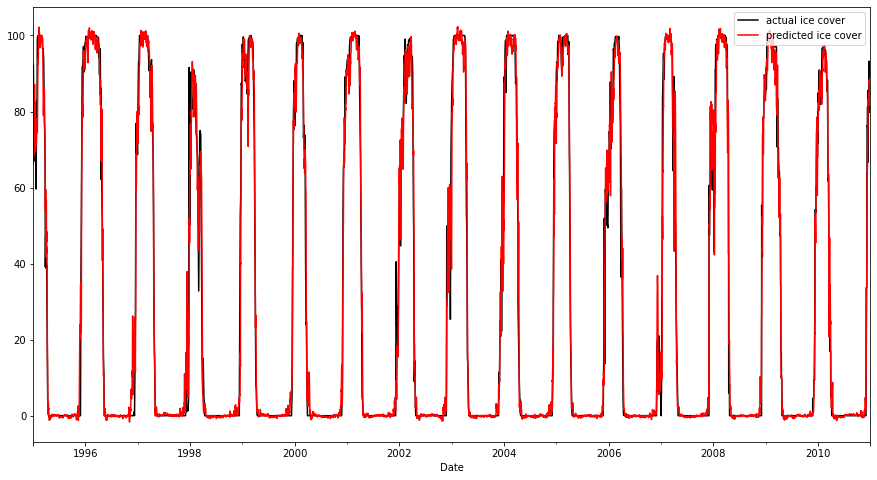

In [42]:
# Overlaying the training predictions on top of training data

X_train['Ice'] = y_train
X_train['Ice_pred'] = y_train_pred

plt.figure(figsize=(15,8))
X_train['Ice'].plot(label = 'actual ice cover', color = 'black')
X_train['Ice_pred'].plot(label = 'predicted ice cover', color = 'red')
plt.legend(loc="upper right")

<ipython-input-43-03a5112f9934>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_valid['Ice'] = y_valid
<ipython-input-43-03a5112f9934>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_valid['Ice_pred'] = y_valid_pred


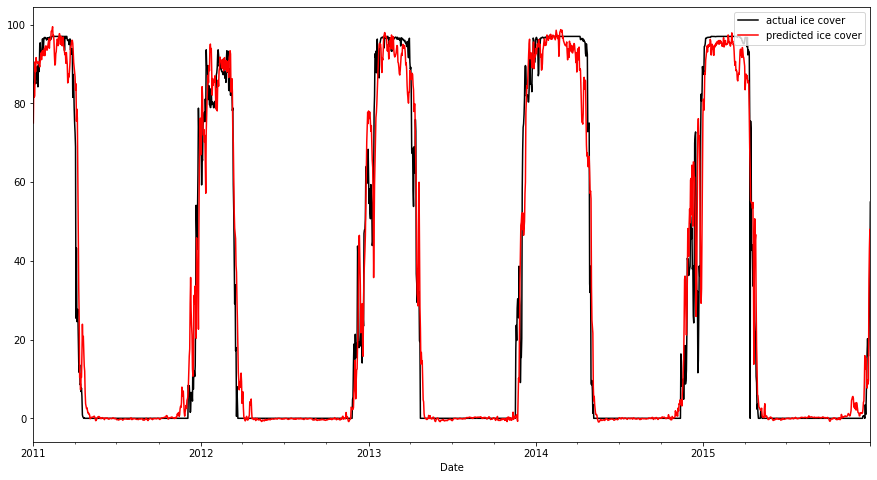

In [43]:
# Overlaying the training predictions on top of validation data

X_valid['Ice'] = y_valid
X_valid['Ice_pred'] = y_valid_pred

plt.figure(figsize=(15,8))
X_valid['Ice'].plot(label = 'actual ice cover', color = 'black')
X_valid['Ice_pred'].plot(label = 'predicted ice cover', color = 'red')
plt.legend(loc="upper right")

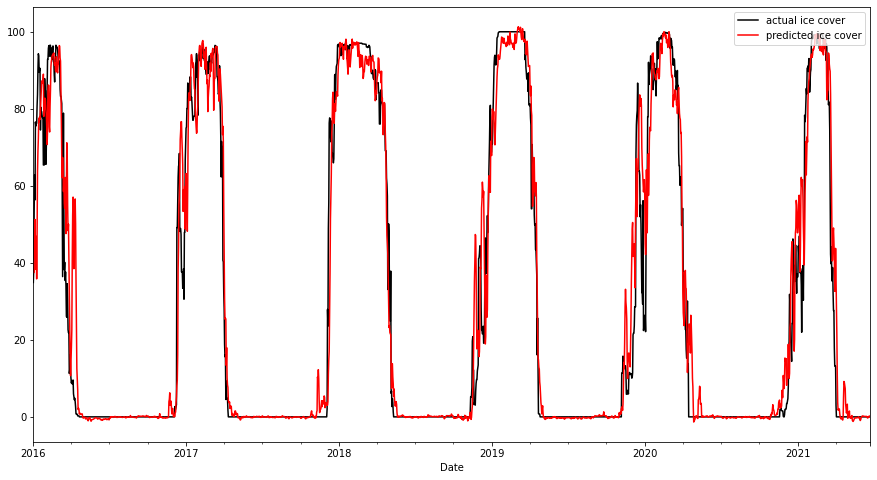

In [44]:
# Overlaying the training predictions on top of test data

X_test['Ice'] = y_test
X_test['Ice_pred'] = y_test_pred

plt.figure(figsize=(15,8))
X_test['Ice'].plot(label = 'actual ice cover', color = 'black')
X_test['Ice_pred'].plot(label = 'predicted ice cover', color = 'red')
plt.legend(loc="upper right")

In [45]:
df_period = df_data.reset_index()
df_period['year'] = pd.DatetimeIndex(df_period['Date']).year
df_period['month'] = pd.DatetimeIndex(df_period['Date']).month
df_period['day'] = pd.DatetimeIndex(df_period['Date']).day
df_period = df_period.set_index('Date')
df_period.tail()

,Ice,Ice1,Ice2,Ice3,u-wind,v-wind,pressure,humidity,temperature,u-wind1,...,PNA2,EPNP2,SOI2,NAO3,PNA3,EPNP3,SOI3,year,month,day
Date,,,,,,,,,,,,,,,,,,,,,
2021-06-19,0.0,0.0,0.0,0.0,0.620657,0.401869,0.368218,0.360000,0.742597,0.657628,...,0.652655,0.391597,0.583333,0.690559,0.652655,0.391597,0.583333,2021,6,19
2021-06-20,0.0,0.0,0.0,0.0,0.565975,0.500131,0.377749,0.326957,0.725971,0.620657,...,0.652655,0.391597,0.583333,0.690559,0.652655,0.391597,0.583333,2021,6,20
2021-06-21,0.0,0.0,0.0,0.0,0.536508,0.449694,0.222665,0.520000,0.708856,0.565975,...,0.652655,0.391597,0.583333,0.690559,0.652655,0.391597,0.583333,2021,6,21
2021-06-22,0.0,0.0,0.0,0.0,0.591544,0.423147,0.441502,0.274783,0.653810,0.536508,...,0.652655,0.391597,0.583333,0.690559,0.652655,0.391597,0.583333,2021,6,22
2021-06-23,0.0,0.0,0.0,0.0,0.539980,0.649380,0.512442,0.330435,0.716457,0.591544,...,0.652655,0.391597,0.583333,0.690559,0.652655,0.391597,0.583333,2021,6,23


In [46]:
########## Freezing Phase: Nov 01 - Jan 14
########## Stable Phase: Jan 15 - Mar 25
########## Melting Phase: Mar 26 - May 10
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
df_freezing = df_period[df_period['month'].isin([10, 11, 12, 1])]
df_freezing = df_freezing[~((df_freezing['month'] == 10) & (df_freezing['day'] < 25))]
df_freezing = df_freezing[~((df_freezing['month'] == 1) & (df_freezing['day'] > 7))]

#### Training XGBoost Model on freezing period

In [47]:
# Separating the Independent and dependent variables

X = df_freezing.drop(['Ice'], axis = 1)
y = df_freezing['Ice']

X = X.drop(['year', 'month', 'day'], axis = 1)

In [48]:
# Predicting on the testation data and calculating the mean absolute error

y_pred = xgb_grid.predict(X)
y_test_pred[y_test_pred < 0] = 0

print(mean_absolute_error(y, y_pred))
print(math.sqrt(mean_squared_error(y, y_pred)))

6.893413287922238
11.562165362860009


### Modeling for Stable Period

In [49]:
########## Freezing Phase: Nov 01 - Jan 14
########## Stable Phase: Jan 15 - Mar 25
########## Melting Phase: Mar 26 - May 10
df_stable = df_period[df_period['month'].isin([1, 2, 3])]
df_stable = df_stable[~((df_stable['month'] == 1) & (df_stable['day'] < 8))]
df_stable = df_stable[~((df_stable['month'] == 3) & (df_stable['day'] > 18))]

In [50]:
# Separating the Independent and dependent variables

X = df_stable.drop(['Ice'], axis = 1)
y = df_stable['Ice']

X = X.drop(['year', 'month', 'day'], axis = 1)

In [51]:
# Predicting on the training data and calculating the mean absolute error

y_pred = xgb_grid.predict(X)

print(mean_absolute_error(y, y_pred))
print(math.sqrt(mean_squared_error(y, y_pred)))

4.143063868287978
6.654961102588654


### Modeling for Melting Period

In [52]:
########## Freezing Phase: Nov 01 - Jan 14
########## Stable Phase: Jan 15 - Mar 25
########## Melting Phase: Mar 26 - May 10
df_melting = df_period[df_period['month'].isin([3, 4, 5])]
df_melting = df_melting[~((df_melting['month'] == 3) & (df_melting['day'] < 19))]
df_melting = df_melting[~((df_melting['month'] == 5) & (df_melting['day'] > 3))]

In [53]:
# Separating the Independent and dependent variables

X = df_melting.drop(['Ice'], axis = 1)
y = df_melting['Ice']

X = X.drop(['year', 'month', 'day'], axis = 1)

In [54]:
# Predicting on the testation data and calculating the mean absolute error

y_pred = xgb_grid.predict(X)
y_pred[y_pred < 0] = 0

print(mean_absolute_error(y, y_pred))
print(math.sqrt(mean_squared_error(y, y_pred)))

7.471508362025196
11.593381120568083


# 35 Day forecast

In [55]:
df_data = ice_data.merge(df_norm, on = 'Date', how = 'inner')
df_data = df_data.set_index('Date')
df_data.head(10)

,Ice,Ice1,Ice2,Ice3,u-wind,v-wind,pressure,humidity,temperature,u-wind1,v-wind1,pressure1,humidity1,temperature1,u-wind2,v-wind2,pressure2,humidity2,temperature2,u-wind3,v-wind3,pressure3,humidity3,temperature3,Sup.,Huron,Sup.1,Huron1,Sup.2,Huron2,Sup.3,Huron3,NAO,PNA,EPNP,SOI,NAO1,PNA1,EPNP1,SOI1,NAO2,PNA2,EPNP2,SOI2,NAO3,PNA3,EPNP3,SOI3
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1995-01-01,0.000000,NaN,NaN,NaN,0.615115,0.473178,0.516700,0.384348,0.417669,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.153884,0.190603,NaN,NaN,NaN,NaN,NaN,NaN,0.718531,0.650442,0.608403,0.45,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1995-01-02,0.000000,0.000000,NaN,NaN,0.711702,0.427545,0.410524,0.316522,0.372446,0.615115,0.473178,0.516700,0.384348,0.417669,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.153386,0.188387,0.153884,0.190603,NaN,NaN,NaN,NaN,0.718531,0.650442,0.608403,0.45,0.718531,0.650442,0.608403,0.45,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1995-01-03,0.000000,0.000000,0.0,NaN,0.823125,0.550553,0.469706,0.200000,0.334305,0.711702,0.427545,0.410524,0.316522,0.372446,0.615115,0.473178,0.516700,0.384348,0.417669,NaN,NaN,NaN,NaN,NaN,0.152888,0.185727,0.153386,0.188387,0.153884,0.190603,NaN,NaN,0.718531,0.650442,0.608403,0.45,0.718531,0.650442,0.608403,0.45,0.718531,0.650442,0.608403,0.45,NaN,NaN,NaN,NaN
1995-01-04,0.000000,0.000000,0.0,0.0,0.693539,0.417617,0.548576,0.064348,0.222110,0.823125,0.550553,0.469706,0.200000,0.334305,0.711702,0.427545,0.410524,0.316522,0.372446,0.615115,0.473178,0.516700,0.384348,0.417669,0.152888,0.183067,0.152888,0.185727,0.153386,0.188387,0.153884,0.190603,0.718531,0.650442,0.608403,0.45,0.718531,0.650442,0.608403,0.45,0.718531,0.650442,0.608403,0.45,0.718531,0.650442,0.608403,0.45
1995-01-05,0.000000,0.000000,0.0,0.0,0.908127,0.696900,0.491621,0.193043,0.314086,0.693539,0.417617,0.548576,0.064348,0.222110,0.823125,0.550553,0.469706,0.200000,0.334305,0.711702,0.427545,0.410524,0.316522,0.372446,0.150398,0.176418,0.152888,0.183067,0.152888,0.185727,0.153386,0.188387,0.718531,0.650442,0.608403,0.45,0.718531,0.650442,0.608403,0.45,0.718531,0.650442,0.608403,0.45,0.718531,0.650442,0.608403,0.45
1995-01-06,0.000000,0.000000,0.0,0.0,0.812893,0.670948,0.310442,0.469565,0.396245,0.908127,0.696900,0.491621,0.193043,0.314086,0.693539,0.417617,0.548576,0.064348,0.222110,0.823125,0.550553,0.469706,0.200000,0.334305,0.148904,0.171099,0.150398,0.176418,0.152888,0.183067,0.152888,0.185727,0.718531,0.650442,0.608403,0.45,0.718531,0.650442,0.608403,0.45,0.718531,0.650442,0.608403,0.45,0.718531,0.650442,0.608403,0.45
1995-01-07,0.000000,0.000000,0.0,0.0,0.481618,0.299704,0.388609,0.073043,0.271408,0.812893,0.670948,0.310442,0.469565,0.396245,0.908127,0.696900,0.491621,0.193043,0.314086,0.693539,0.417617,0.548576,0.064348,0.222110,0.146414,0.164007,0.148904,0.171099,0.150398,0.176418,0.152888,0.183067,0.718531,0.650442,0.608403,0.45,0.718531,0.650442,0.608403,0.45,0.718531,0.650442,0.608403,0.45,0.718531,0.650442,0.608403,0.45
1995-01-08,0.000000,0.000000,0.0,0.0,0.693795,0.656318,0.402438,0.123478,0.317334,0.481618,0.299704,0.388609,0.073043,0.271408,0.812893,0.670948,0.310442,0.469565,0.396245,0.908127,0.696900,0.491621,0.193043,0.314086,0.144422,0.157358,0.146414,0.164007,0.148904,0.171099,0.150398,0.176418,0.718531,0.650442,0.608403,0.45,0.718531,0.650442,0.608403,0.45,0.718531,0.650442,0.608403,0.45,0.718531,0.650442,0.608403,0.45
1995-01-09,62.446242,0.000000,0.0,0.0,0.712981,0.459854,0.593343,0.074783,0.283050,0.693795,0.656318,0.402438,0.123478,0.317334,0.481618,0.299704,0.388609,0.073043,0.271408,0.812893,0.670948,0.310442,0.469565,0.396245,0.140438,0.150266,0.144422,0.157358,0.146414,0.164007,0.148904,0.171099,0.718531,0.650442,0.608403,0.45,0.718531,0.650442,0.608403,0.45,0.718531,0.650442,0.608403,0.45,0.718531,0.650442,0.608403,0.45


In [56]:
df_data['Ice'] = df_data['Ice'].shift(-35)
df_data = df_data.dropna()

In [57]:
X = df_data.drop(['Ice'], axis = 1) ####### This is to include ice lags
###### X = df_data.drop(['Ice', 'Ice1', 'Ice2', 'Ice3'], axis = 1) ########## This is to exclude ice lags
y = df_data['Ice']

In [58]:
X_train = X['1995-01-01':'2010-12-31']
X_valid = X['2011-01-01':'2015-12-31']
y_train = y['1995-01-01':'2010-12-31']
y_valid = y['2011-01-01':'2015-12-31']

print(X_train.shape, y_train.shape)
print(X_valid.shape, y_valid.shape)

(5841, 47) (5841,)
(1826, 47) (1826,)


In [59]:
X_test = X['2016-01-01':'2021-06-30']
y_test = y['2016-01-01':'2021-06-30']
print(X_test.shape, y_test.shape)

(1973, 47) (1973,)


In [60]:
# Running the XGBoost regressor with a wide range of hyper parameters and timeseries split
import time
t0 = time.time()

xgb1 = xgb.XGBRegressor()
parameters = {'objective' : ['reg:squarederror'],
              #'objective':['reg:tweedie'],
              'booster': ['gbtree', 'gblinear'],
              'early_stopping_rounds' : [20],
              'learning_rate': [0.005],
              'max_depth': [3],
              'subsample': [0.5, 0.6, 0.7],
              'colsample_bytree': [0.5, 0.6],
              'n_estimators': [1500],
              'eval_metric' : ['rmse'],
              'eval_set' : [[X_valid, y_valid]]}

tscv = TimeSeriesSplit(n_splits=10)

xgb_grid = GridSearchCV(xgb1,
                        parameters,
                        n_jobs = -1,
                        cv = tscv,
                        verbose=True)

xgb_grid.fit(X_train, y_train)

tF = time.time()

print(xgb_grid.best_score_)
print(xgb_grid.best_params_)

print('Time to train = %.2f seconds' % (tF - t0))

Fitting 10 folds for each of 12 candidates, totalling 120 fits
[04:39:43] WARNING: ..\src\learner.cc:541: 
Parameters: { early_stopping_rounds, eval_set } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


0.6562709660975046
{'booster': 'gbtree', 'colsample_bytree': 0.6, 'early_stopping_rounds': 20, 'eval_metric': 'rmse', 'eval_set': [                 Ice1       Ice2       Ice3    u-wind    v-wind  pressure  \
Date                                                                        
2011-01-01  90.160346  89.930617  93.241438  0.494847  0.702764  0.300207   
2011-01-02  90.160346  90.160346  89.930617  0.761438  0.670542  0.419040   
2011-01-03  85.904482  90.160346  90.160346  0.656702  0.591091  0.508692   
2011-01-04  79.836571  85.904482  90.160346  0.519295  0.520480  0.421

In [61]:
# Predicting on the Training data and calculating the mean absolute error

y_train_pred = xgb_grid.predict(X_train)

print(mean_absolute_error(y_train, y_train_pred))
print(math.sqrt(mean_squared_error(y_train, y_train_pred)))

8.022043561337428
13.40580138360107


In [62]:
# Predicting on the Validation data and calculating the mean absolute error

y_valid_pred = xgb_grid.predict(X_valid)

print(mean_absolute_error(y_valid, y_valid_pred))
print(math.sqrt(mean_squared_error(y_valid, y_valid_pred)))

11.798317428024637
20.11307275811811


In [63]:
# Predicting on the test data and calculating the mean absolute error

X_test = X_test.dropna()
y_test = y_test.dropna()

y_test_pred = xgb_grid.predict(X_test)

print(mean_absolute_error(y_test, y_test_pred))
print(math.sqrt(mean_squared_error(y_test, y_test_pred)))

12.737706894019233
21.38774419940209


<AxesSubplot:ylabel='feature'>

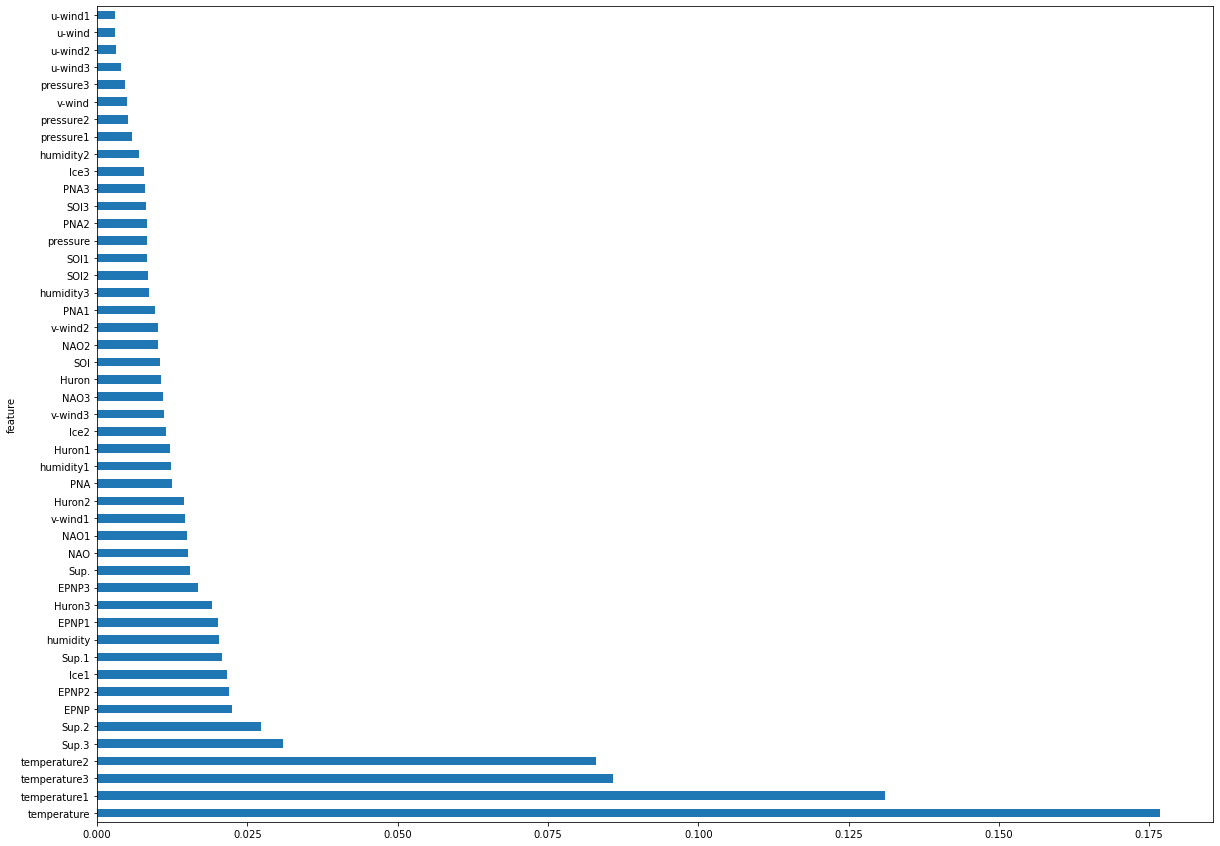

In [64]:
# Calculating variable importance as per the XGBoost model.

var_importance = pd.DataFrame(xgb_grid.best_estimator_.feature_importances_)
features = pd.DataFrame(X_test.columns)
df_var_imp = pd.concat([features, var_importance], axis = 1)
df_var_imp.columns = ['feature', 'importance']
df_var_imp = df_var_imp.sort_values(by = ['importance'], ascending = False)
df_var_imp = df_var_imp.set_index(['feature'])

# Displaying the variable importance

%matplotlib inline
fig, ax = plt.subplots(figsize=(20, 15))
#plt.figure(figsize=(10,10))
df_var_imp['importance'].plot(kind = 'barh')

<ipython-input-65-785c215a319c>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['Ice'] = y_train
<ipython-input-65-785c215a319c>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['Ice_pred'] = y_train_pred


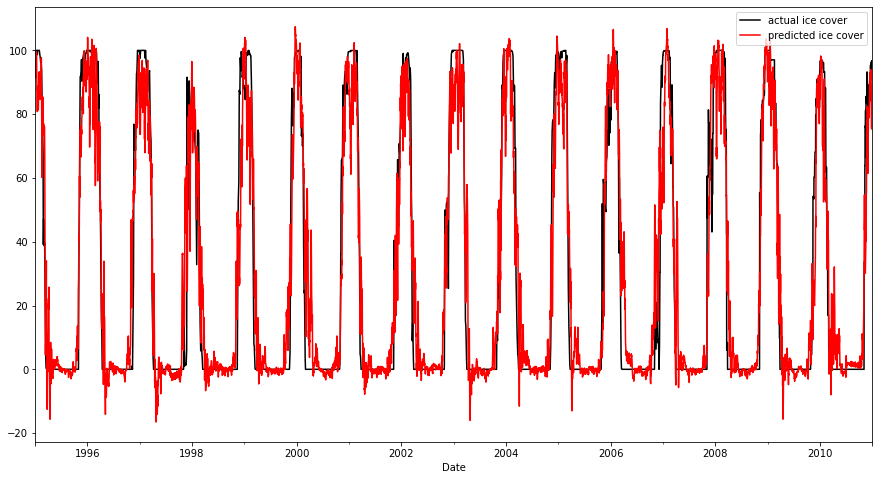

In [65]:
# Overlaying the training predictions on top of training data

X_train['Ice'] = y_train
X_train['Ice_pred'] = y_train_pred

plt.figure(figsize=(15,8))
X_train['Ice'].plot(label = 'actual ice cover', color = 'black')
X_train['Ice_pred'].plot(label = 'predicted ice cover', color = 'red')
plt.legend(loc="upper right")

<ipython-input-66-03a5112f9934>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_valid['Ice'] = y_valid
<ipython-input-66-03a5112f9934>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_valid['Ice_pred'] = y_valid_pred


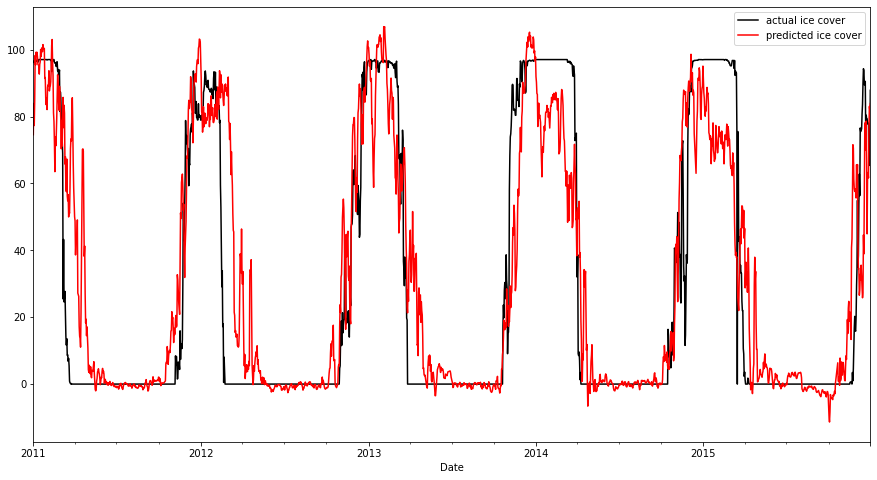

In [66]:
# Overlaying the training predictions on top of validation data

X_valid['Ice'] = y_valid
X_valid['Ice_pred'] = y_valid_pred

plt.figure(figsize=(15,8))
X_valid['Ice'].plot(label = 'actual ice cover', color = 'black')
X_valid['Ice_pred'].plot(label = 'predicted ice cover', color = 'red')
plt.legend(loc="upper right")

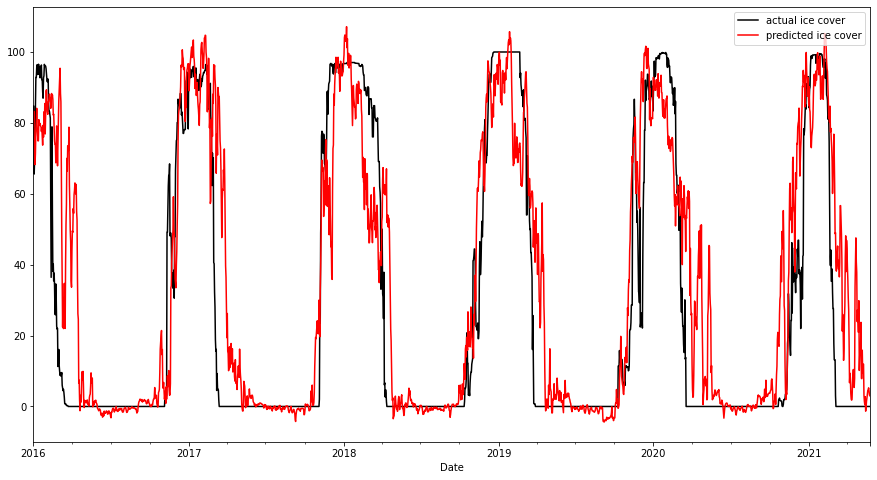

In [67]:
# Overlaying the training predictions on top of test data

X_test['Ice'] = y_test
X_test['Ice_pred'] = y_test_pred

plt.figure(figsize=(15,8))
X_test['Ice'].plot(label = 'actual ice cover', color = 'black')
X_test['Ice_pred'].plot(label = 'predicted ice cover', color = 'red')
plt.legend(loc="upper right")

In [68]:
df_period = df_data.reset_index()
df_period['year'] = pd.DatetimeIndex(df_period['Date']).year
df_period['month'] = pd.DatetimeIndex(df_period['Date']).month
df_period['day'] = pd.DatetimeIndex(df_period['Date']).day
df_period = df_period.set_index('Date')
df_period.tail()

,Ice,Ice1,Ice2,Ice3,u-wind,v-wind,pressure,humidity,temperature,u-wind1,v-wind1,pressure1,humidity1,temperature1,u-wind2,v-wind2,pressure2,humidity2,temperature2,u-wind3,v-wind3,pressure3,humidity3,temperature3,Sup.,Huron,Sup.1,Huron1,Sup.2,Huron2,Sup.3,Huron3,NAO,PNA,EPNP,SOI,NAO1,PNA1,EPNP1,SOI1,NAO2,PNA2,EPNP2,SOI2,NAO3,PNA3,EPNP3,SOI3,year,month,day
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-05-22,0.0,0.0,0.0,0.0,0.620864,0.625882,0.670534,0.615652,0.764262,0.496979,0.647319,0.704989,0.553043,0.819560,0.425194,0.665491,0.688035,0.606957,0.773771,0.354578,0.655621,0.684636,0.441739,0.729689,0.224104,0.345301,0.214143,0.325355,0.210657,0.315160,0.211155,0.316489,0.339161,0.205752,0.435294,0.6,0.339161,0.205752,0.435294,0.6,0.339161,0.205752,0.435294,0.6,0.339161,0.205752,0.435294,0.6,2021,5,22
2021-05-23,0.0,0.0,0.0,0.0,0.468828,0.481407,0.632056,0.549565,0.748427,0.620864,0.625882,0.670534,0.615652,0.764262,0.496979,0.647319,0.704989,0.553043,0.819560,0.425194,0.665491,0.688035,0.606957,0.773771,0.229582,0.364362,0.224104,0.345301,0.214143,0.325355,0.210657,0.315160,0.339161,0.205752,0.435294,0.6,0.339161,0.205752,0.435294,0.6,0.339161,0.205752,0.435294,0.6,0.339161,0.205752,0.435294,0.6,2021,5,23
2021-05-24,0.0,0.0,0.0,0.0,0.356844,0.627740,0.658737,0.438261,0.676849,0.468828,0.481407,0.632056,0.549565,0.748427,0.620864,0.625882,0.670534,0.615652,0.764262,0.496979,0.647319,0.704989,0.553043,0.819560,0.236554,0.371454,0.229582,0.364362,0.224104,0.345301,0.214143,0.325355,0.339161,0.205752,0.435294,0.6,0.339161,0.205752,0.435294,0.6,0.339161,0.205752,0.435294,0.6,0.339161,0.205752,0.435294,0.6,2021,5,24
2021-05-25,0.0,0.0,0.0,0.0,0.528115,0.669192,0.470097,0.620870,0.765192,0.356844,0.627740,0.658737,0.438261,0.676849,0.468828,0.481407,0.632056,0.549565,0.748427,0.620864,0.625882,0.670534,0.615652,0.764262,0.231574,0.376330,0.236554,0.371454,0.229582,0.364362,0.224104,0.345301,0.339161,0.205752,0.435294,0.6,0.339161,0.205752,0.435294,0.6,0.339161,0.205752,0.435294,0.6,0.339161,0.205752,0.435294,0.6,2021,5,25
2021-05-26,0.0,0.0,0.0,0.0,0.773815,0.545038,0.398726,0.382609,0.765054,0.528115,0.669192,0.470097,0.620870,0.765192,0.356844,0.627740,0.658737,0.438261,0.676849,0.468828,0.481407,0.632056,0.549565,0.748427,0.215637,0.369681,0.231574,0.376330,0.236554,0.371454,0.229582,0.364362,0.339161,0.205752,0.435294,0.6,0.339161,0.205752,0.435294,0.6,0.339161,0.205752,0.435294,0.6,0.339161,0.205752,0.435294,0.6,2021,5,26


In [69]:
########## Freezing Phase: Nov 01 - Jan 14
########## Stable Phase: Jan 15 - Mar 25
########## Melting Phase: Mar 26 - May 10
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
df_freezing = df_period[df_period['month'].isin([10, 11, 12])]
df_freezing = df_freezing[~((df_freezing['month'] == 10) & (df_freezing['day'] < 2))]
df_freezing = df_freezing[~((df_freezing['month'] == 12) & (df_freezing['day'] > 15))]

#### Training XGBoost Model on freezing period

In [70]:
# Separating the Independent and dependent variables

X = df_freezing.drop(['Ice'], axis = 1)
y = df_freezing['Ice']

X = X.drop(['year', 'month', 'day'], axis = 1)

In [71]:
# Predicting on the testation data and calculating the mean absolute error

y_pred = xgb_grid.predict(X)
y_pred[y_pred < 0] = 0

print(mean_absolute_error(y, y_pred))
print(math.sqrt(mean_squared_error(y, y_pred)))

14.288394367636924
20.578859697495748


### Modeling for Stable Period

In [72]:
########## Freezing Phase: Nov 01 - Jan 14
########## Stable Phase: Jan 15 - Mar 25
########## Melting Phase: Mar 26 - May 10
df_stable = df_period[df_period['month'].isin([12, 1, 2])]
df_stable = df_stable[~((df_stable['month'] == 12) & (df_stable['day'] < 16))]
df_stable = df_stable[~((df_stable['month'] == 2) & (df_stable['day'] > 23))]

In [73]:
# Separating the Independent and dependent variables

X = df_stable.drop(['Ice'], axis = 1)
y = df_stable['Ice']

X = X.drop(['year', 'month', 'day'], axis = 1)

In [74]:
# Predicting on the testation data and calculating the mean absolute error

y_pred = xgb_grid.predict(X)
y_pred[y_pred < 0] = 0

print(mean_absolute_error(y, y_pred))
print(math.sqrt(mean_squared_error(y, y_pred)))

11.683622580254983
15.598508000043074


### Modeling for Melting Period

In [75]:
########## Freezing Phase: Nov 01 - Jan 14
########## Stable Phase: Jan 15 - Mar 25
########## Melting Phase: Mar 26 - May 10
df_melting = df_period[df_period['month'].isin([2, 3, 4])]
df_melting = df_melting[~((df_melting['month'] == 2) & (df_melting['day'] < 24))]
df_melting = df_melting[~((df_melting['month'] == 4) & (df_melting['day'] > 10))]

In [76]:
# Separating the Independent and dependent variables

X = df_melting.drop(['Ice'], axis = 1)
y = df_melting['Ice']

X = X.drop(['year', 'month', 'day'], axis = 1)

In [77]:
# Predicting on the testation data and calculating the mean absolute error

y_pred = xgb_grid.predict(X)
y_pred[y_pred < 0] = 0

print(mean_absolute_error(y, y_pred))
print(math.sqrt(mean_squared_error(y, y_pred)))

24.542131765402647
30.845436162451556
